# **Diyora Ujas Vinodkumar 224161002**
## part 1
### I'm using two different files one for slecting a particular stocks or not , using **technical indicator and fundamental analysis** then predicting the price of that stock using **LSTM** and
### a second model for reduce bit more no of size of our stocks with having a diversified portfolio that can have maximum sharpe ratio(using markov efficient furntier) and finding out the weightage of each stocks.


In [ ]:
import math
import pandas as pd
import numpy as np
from datetime import date,timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dense
import tensorflow as tf
import seaborn as sns
sns.set_style('white',{'axes.spines.right' : False , 'axes.spines.top':False})

In [ ]:
#today = date.today()
#end_date = today.strftime("%Y-%m-%d")
start_date = '2010-01-01'
end_date = '2020-01-01'

stockname = 'COST'
symbol = 'COST'

In [ ]:
import yfinance as yf
df = yf.download(symbol,start = start_date,end = end_date ,  interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df,df.shape

(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2010-01-04   59.130001   60.070000   59.130001   59.410000   43.852654   
 2010-01-05   59.259998   59.419998   58.840000   59.230000   43.719784   
 2010-01-06   59.070000   60.049999   59.000000   60.000000   44.288166   
 2010-01-07   60.080002   60.439999   59.259998   59.709999   44.074093   
 2010-01-08   59.470001   59.610001   59.099998   59.279999   43.756687   
 ...                ...         ...         ...         ...         ...   
 2019-12-24  293.910004  294.450012  293.359985  294.230011  279.790009   
 2019-12-26  294.489990  295.730011  293.899994  295.730011  281.216339   
 2019-12-27  296.220001  296.299988  293.179993  294.109985  279.675842   
 2019-12-30  294.200012  295.609985  293.660004  295.140015  280.655365   
 2019-12-31  295.000000  295.450012  292.179993  293.920013  279.495270   
 
              Volume  


In [ ]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Day'] = d.strftime("%d")
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y")
train_df

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
Date,,,,,,,,,
2010-01-04,59.130001,60.070000,59.130001,59.410000,43.852654,3280200,04,01,2010
2010-01-05,59.259998,59.419998,58.840000,59.230000,43.719784,2775800,05,01,2010
2010-01-06,59.070000,60.049999,59.000000,60.000000,44.288166,3722900,06,01,2010
2010-01-07,60.080002,60.439999,59.259998,59.709999,44.074093,4527600,07,01,2010
2010-01-08,59.470001,59.610001,59.099998,59.279999,43.756687,2348300,08,01,2010
...,...,...,...,...,...,...,...,...,...
2019-12-24,293.910004,294.450012,293.359985,294.230011,279.790009,543600,24,12,2019
2019-12-26,294.489990,295.730011,293.899994,295.730011,281.216339,1101800,26,12,2019
2019-12-27,296.220001,296.299988,293.179993,294.109985,279.675842,1439100,27,12,2019


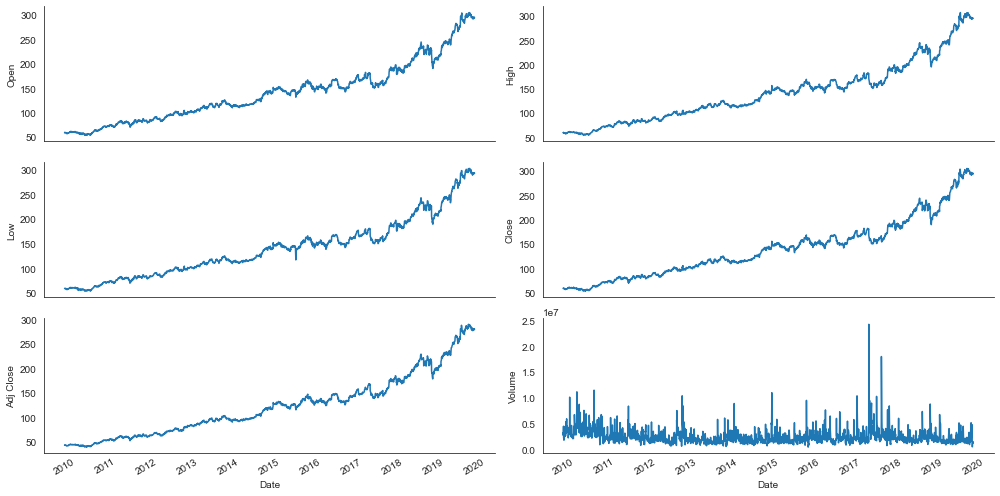

In [ ]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

**I will use following strategy to select any stock in my portfolio**

### A . Relative Strength Index (RSI)
The Relative Strength Index (RSI) is one of the most commonly used oscillating indicators. In 1978, Welles Wilder developed it to determine the momentum of price movements and compare the strength of price losses in a period with price gains. It can take percentage values between 0 and 100.


**I will use this as my first strategy to select any stock(to filter a stock), by following strategy if RSI will give a upward tred than it will be selected**
### 1. The reference line is at 40% (oversold) and 80% (overbought) with an upward trend.
### 2. The reference line is at 20% (oversold) and 60% (overbought) with a downtrend.

using indicators

In [ ]:
def createFeatures(df):
    df = pd.DataFrame(df)


    df['Close_Diff'] = df['Adj Close'].diff()

    # Relative Strength Index (RSI)
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA14_high'] = df['High'].rolling(window=14).max()

    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean()



    return df

             Adj Close        RSI
Date                             
2019-12-24  279.790009  58.006045
2019-12-26  281.216339  61.470341
2019-12-27  279.675842  64.549584
2019-12-30  280.655365  68.052291
2019-12-31  279.495270  61.085406


<function matplotlib.pyplot.show(close=None, block=None)>

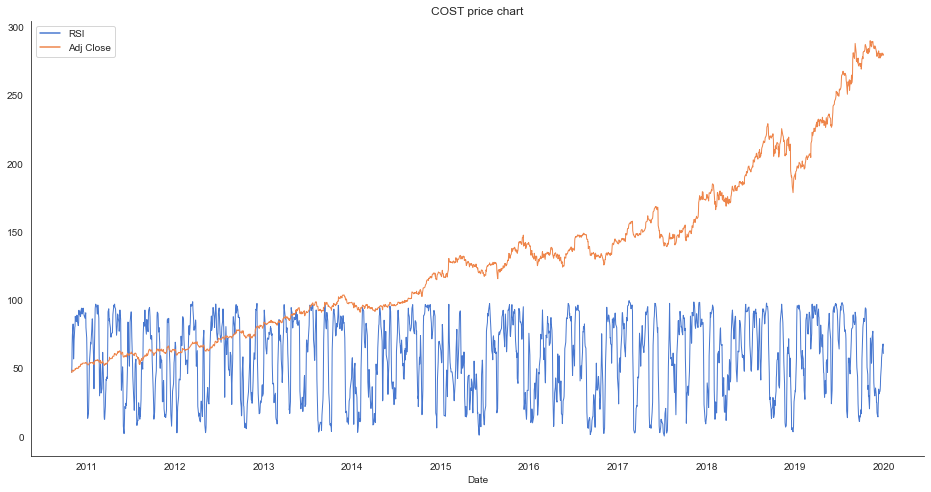

In [ ]:
FEATURES = [

            'Adj Close',
            'RSI',
           ]

# Create the dataset with features
df_features = createFeatures(train_df)

# Shift the timeframe by 10 month
use_start_date = pd.to_datetime("2010-11-01" )
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
data_filtered_ext = df_features[FEATURES].copy()

# We add a prediction column and set dummy values to prepare the data for scaling
#data_filtered_ext['Prediction'] = data_filtered_ext['Close']
print(data_filtered_ext.tail().to_string())

# remove Date column before training
dfs = data_filtered_ext.copy()

# Create a list with the relevant columns
assetname_list = [dfs.columns[i-1] for i in range(dfs.shape[1])]

# Create the lineplot
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=data_filtered_ext[assetname_list], linewidth=1.0, dashes=False, palette='muted')

# Configure and show the plot
ax.set_title(stockname + ' price chart')
ax.legend()
plt.show

## B . Bollinger Bands                                                  
Bollinger Bands are a popular technical analysis tool used to identify market volatility and potential price movements in financial markets.Bollinger Bands consist of three lines that are plotted on a price chart. The middle line is a simple moving average (SMA) of the asset price over a specified period (typically 20 days). The upper and lower lines are calculated by adding and subtracting a multiple (usually two) of the standard deviation of the asset price from the middle line.


The upper band is calculated as: Middle band + (2 x Standard deviation) The lower band is calculated as: Middle band – (2 x Standard deviation)
**When the asset price is more volatile, the bands widen, and when the price is less volatile, the bands narrow.**
## we can use this as **our second strategy** if prices are toching or crossing the lower band , it is indicating a buy signal that asset is oversold.


In [ ]:
def createFeaturesB(df):
    df = pd.DataFrame(df)

    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std()

     # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)




    return df

             Adj Close  Bollinger_Upper  Bollinger_Lower
Date                                                    
2019-12-24  279.790009       300.900991       290.288008
2019-12-26  281.216339       299.916101       290.721899
2019-12-27  279.675842       298.826163       291.146835
2019-12-30  280.655365       297.854658       291.651342
2019-12-31  279.495270       297.438808       291.720191


<function matplotlib.pyplot.show(close=None, block=None)>

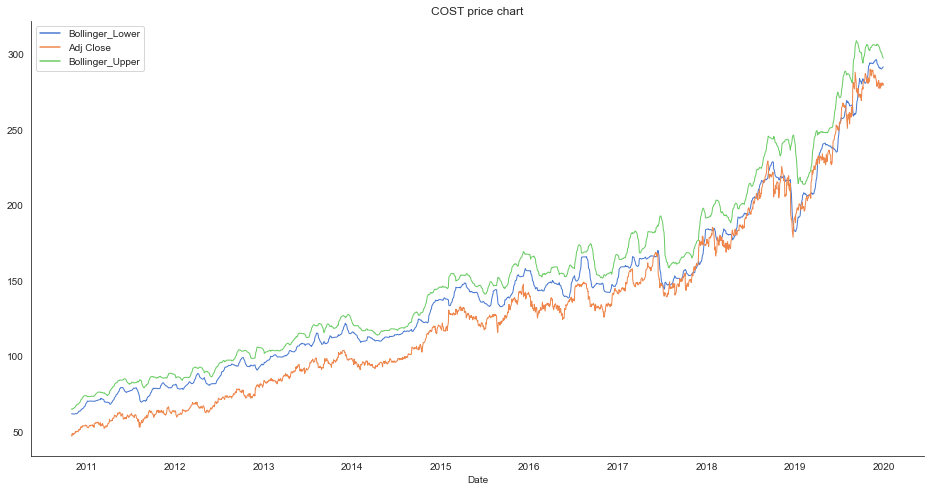

In [ ]:
FEATURESB = [

            'Adj Close',
            'Bollinger_Upper',
            'Bollinger_Lower'
           ]

# Create the dataset with features
df_featuresB = createFeaturesB(train_df)


df_featuresB = df_featuresB[df_featuresB.index > use_start_date].copy()

# Filter the data to the list of FEATURES
data_filtered_extB = df_featuresB[FEATURESB].copy()

# We add a prediction column and set dummy values to prepare the data for scaling
#data_filtered_ext['Prediction'] = data_filtered_ext['Close']
print(data_filtered_extB.tail().to_string())

# remove Date column before training
dfsB = data_filtered_extB.copy()

# Create a list with the relevant columns
assetname_listB = [dfsB.columns[i-1] for i in range(dfsB.shape[1])]

# Create the lineplot
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=data_filtered_extB[assetname_listB], linewidth=1.0, dashes=False, palette='muted')

# Configure and show the plot
ax.set_title(stockname + ' price chart')
ax.legend()
plt.show

In [ ]:
data_filtered_ext , data_filtered_extB

(             Adj Close        RSI
 Date                             
 2010-11-02   47.666313  47.270648
 2010-11-03   47.247387  51.800265
 2010-11-04   48.982887  67.765299
 2010-11-05   48.923042  74.807414
 2010-11-08   48.481674  82.688627
 ...                ...        ...
 2019-12-24  279.790009  58.006045
 2019-12-26  281.216339  61.470341
 2019-12-27  279.675842  64.549584
 2019-12-30  280.655365  68.052291
 2019-12-31  279.495270  61.085406
 
 [2306 rows x 2 columns],
              Adj Close  Bollinger_Upper  Bollinger_Lower
 Date                                                    
 2010-11-02   47.666313        65.227023        61.958977
 2010-11-03   47.247387        64.880914        62.080086
 2010-11-04   48.982887        64.952896        62.030104
 2010-11-05   48.923042        65.206908        61.887093
 2010-11-08   48.481674        65.292777        61.850223
 ...                ...              ...              ...
 2019-12-24  279.790009       300.900991       290.28

# now we have selected our stock(if it has passed both filter) then we can using LSTM predict our stocks's future Price so that at that point we can make our sell order after getting estimated profit

In [ ]:

train_df = df.filter(['Adj Close'])
data_unscaled = train_df.values

# Get the number of rows to train the model on 80% of the data
train_data_length = math.ceil(len(data_unscaled) * 0.8)

mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [ ]:

sequence_length = 50

index_Close = train_df.columns.get_loc("Adj Close")
print(index_Close)

train_data_len = math.ceil(np_data.shape[0] * 0.8)

train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(train_df[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0
(1963, 50, 1) (1963,)
(503, 50, 1) (503,)
0.5417903788092657
0.5417903788092657


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Configure the neural network model
model = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons
# inputshape = sequence_length Timestamps
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(35, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')




In [ ]:
# Training the model
model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
123/123 [==============================] - 4s 28ms/step - loss: 8.9350e-05
Epoch 2/25
123/123 [==============================] - 3s 28ms/step - loss: 9.4497e-05
Epoch 3/25
123/123 [==============================] - 4s 29ms/step - loss: 7.7922e-05
Epoch 4/25
123/123 [==============================] - 4s 29ms/step - loss: 8.7849e-05
Epoch 5/25
123/123 [==============================] - 4s 31ms/step - loss: 7.9099e-05
Epoch 6/25
123/123 [==============================] - 3s 28ms/step - loss: 8.0956e-05
Epoch 7/25
123/123 [==============================] - 3s 28ms/step - loss: 7.0426e-05
Epoch 8/25
123/123 [==============================] - 4s 30ms/step - loss: 6.9326e-05
Epoch 9/25
123/123 [==============================] - 4s 34ms/step - loss: 7.3176e-05
Epoch 10/25
123/123 [==============================] - 4s 32ms/step - loss: 6.3475e-05
Epoch 11/25
123/123 [==============================] - 4s 32ms/step - loss: 6.8663e-05
Epoch 12/25
123/123 [==============================]

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = mmscaler.inverse_transform(y_pred_scaled)
y_test_unscaled = mmscaler.inverse_transform(y_test.reshape(-1, 1))

16/16 [==============================] - 0s 15ms/step


In [ ]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 4.28
Mean Absolute Percentage Error (MAPE): 1.81 %
Median Absolute Percentage Error (MDAPE): 1.63 %


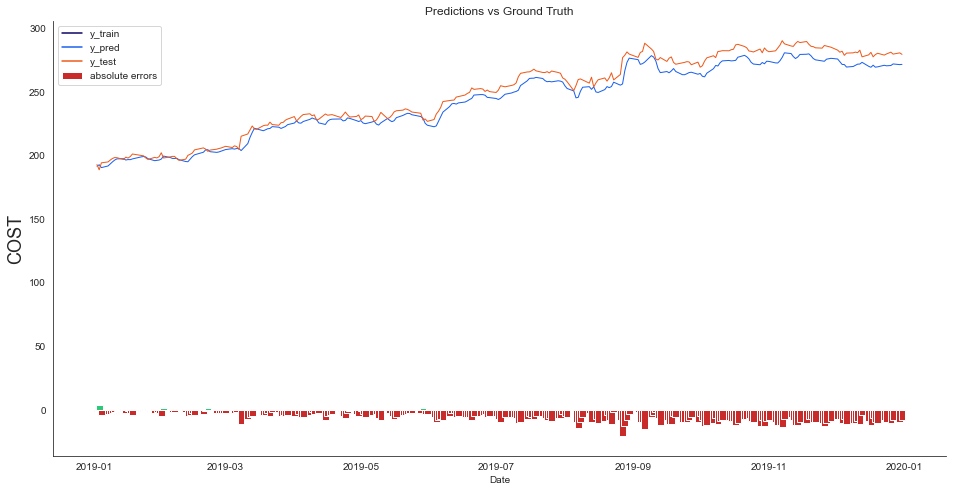

In [ ]:

display_start_date = "2019-01-01"


train = pd.DataFrame(train_df[:train_data_length + 1]).rename(columns={'Adj Close': 'y_train'})
valid = pd.DataFrame(train_df[train_data_length:]).rename(columns={'Adj Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])


df_union_zoom = df_union[df_union.index > display_start_date]


fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("Predictions vs Ground Truth")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
plt.legend()
plt.show()

In [ ]:
# Get fresh data
df_new = df.filter(['Adj Close'])
today = date.today()
# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled = mmscaler.transform(df_new[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new['Adj Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent_change = round((predicted_price * 100)/price_today - 100, 2)

prefix = '+' if percent_change > 0 else ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price for the next day is {predicted_price} ({prefix}{percent_change}%)')

1/1 [==============================] - 0s 33ms/step
The close price for COST at 2023-04-20 was 279.5
The predicted close price for the next day is 270.9200134277344 (-3.07%)
